# Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the data

##### Skipping straight to step three as I'll be using my main project data for the time-series analysis

### 1. Importing libraries and data

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings # This is a library that handles warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate a suspended library

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear

In [161]:
# Create path

path = r'/Users/chadstacey'

In [162]:
# Import movies data

movies = pd.read_pickle(os.path.join(path, 'CF_Final_Project', 'Data', 'Prepared_Data', 'movies_cleaned_1.pkl'))

In [163]:
movies.dtypes

budget                   float64
company                   object
country                   object
director                  object
genre                     object
gross                    float64
name                      object
rating                    object
released          datetime64[ns]
runtime                    int64
score                    float64
star                      object
votes                      int64
writer                    object
year                      object
profit                   float64
score category            object
dtype: object

In [164]:
# Remove categorical variables (except name, country and year)

movies = movies.drop(['company', 'director', 'genre', 'rating', 'star', 'writer', 'score category', 'released'], axis=1)

In [165]:
movies.head()

,budget,country,gross,name,runtime,score,votes,year,profit
0,8000000.0,USA,52287414.0,Stand by Me,89,8.1,299174,1986,44287414.0
1,6000000.0,USA,70136369.0,Ferris Bueller's Day Off,103,7.8,264740,1986,64136369.0
2,15000000.0,USA,179800601.0,Top Gun,110,6.9,236909,1986,164800601.0
3,18500000.0,USA,85160248.0,Aliens,137,8.4,540152,1986,66660248.0
4,9000000.0,USA,18564613.0,Flight of the Navigator,90,6.9,36636,1986,9564613.0


### 2. Subsetting, wrangling, and cleaning time-series data

I am going to perform a time series analysis on the top 100 films (in terms of budget) each year specifically from the US. So I need to create a subset which firstly filters out films which aren't from the US and then focuses on the top 100 from the US between 1986 - 2016.

In [166]:
# Firstly filter out films which arent from the US

us_movies = movies[movies['country'] == 'USA']

In [167]:
us_movies.shape

(4872, 9)

In [168]:
# Then rank these in ascending order in terms of budget and year 

us_movies['rank'] = us_movies.groupby(by=['year'])['budget'].transform(lambda x: x.rank(method="first", ascending=False))

In [169]:
us_movies 

,budget,country,gross,name,runtime,score,votes,year,profit,rank
0,8000000.0,USA,52287414.0,Stand by Me,89,8.1,299174,1986,44287414.0,51.0
1,6000000.0,USA,70136369.0,Ferris Bueller's Day Off,103,7.8,264740,1986,64136369.0,55.0
2,15000000.0,USA,179800601.0,Top Gun,110,6.9,236909,1986,164800601.0,25.0
3,18500000.0,USA,85160248.0,Aliens,137,8.4,540152,1986,66660248.0,15.0
4,9000000.0,USA,18564613.0,Flight of the Navigator,90,6.9,36636,1986,9564613.0,47.0
...,...,...,...,...,...,...,...,...,...,...
6813,0.0,USA,228894.0,The Love Witch,120,6.2,6054,2016,228894.0,132.0
6814,20000000.0,USA,36874745.0,Risen,107,6.3,19084,2016,16874745.0,78.0
6816,0.0,USA,28368.0,Mothers and Daughters,90,4.9,1959,2016,28368.0,133.0
6817,3500000.0,USA,3775000.0,Batman: The Killing Joke,76,6.5,36333,2016,275000.0,110.0


In [170]:
# Then delete any films that fall outside the top 100

us_movies_top = us_movies[us_movies['rank'] <= 100]

In [171]:
# And voila - this is the dataframe I will use for time series analysis

us_movies_top

,budget,country,gross,name,runtime,score,votes,year,profit,rank
0,8000000.0,USA,52287414.0,Stand by Me,89,8.1,299174,1986,44287414.0,51.0
1,6000000.0,USA,70136369.0,Ferris Bueller's Day Off,103,7.8,264740,1986,64136369.0,55.0
2,15000000.0,USA,179800601.0,Top Gun,110,6.9,236909,1986,164800601.0,25.0
3,18500000.0,USA,85160248.0,Aliens,137,8.4,540152,1986,66660248.0,15.0
4,9000000.0,USA,18564613.0,Flight of the Navigator,90,6.9,36636,1986,9564613.0,47.0
...,...,...,...,...,...,...,...,...,...,...
6796,15000000.0,USA,2411580.0,The Disappointments Room,85,3.9,6287,2016,-12588420.0,87.0
6799,18000000.0,USA,59573085.0,My Big Fat Greek Wedding 2,94,6.0,22142,2016,41573085.0,81.0
6800,17000000.0,USA,41715860.0,Almost Christmas,111,6.0,3366,2016,24715860.0,83.0
6811,8500000.0,USA,19985196.0,Middle School: The Worst Years of My Life,92,6.1,4556,2016,11485196.0,98.0


In [172]:
# Drop country column as all the films are from the US

us_movies_top = us_movies_top.drop(['country'], axis=1)

In [173]:
# Create subset with just budget and released

budget_year = us_movies_top.drop(['gross', 'name', 'runtime', 'score', 'votes', 'profit', 'rank'], axis=1)

In [174]:
budget_year

,budget,year
0,8000000.0,1986
1,6000000.0,1986
2,15000000.0,1986
3,18500000.0,1986
4,9000000.0,1986
...,...,...
6796,15000000.0,2016
6799,18000000.0,2016
6800,17000000.0,2016
6811,8500000.0,2016


In [175]:
# Get sum of budgets according to year

budget_year = budget_year.groupby('year')['budget'].sum()

In [176]:
# Check type

type(budget_year)

pandas.core.series.Series

In [177]:
# Convert to dataframe

budget_year = pd.DataFrame(budget_year)

In [178]:
budget_year.head()

,budget
year,
1986,9.588874e+08
1987,9.976450e+08
1988,1.377900e+09
1989,1.377575e+09
1990,1.639217e+09


In [180]:
# Reset index

budget_year = budget_year.reset_index()

In [181]:
from datetime import datetime

budget_year['datetime'] = pd.to_datetime(budget_year['year'], format='%Y') # Create a datetime column from 'year'
budget_year = budget_year.set_index('datetime') # Set the datetime as the index of the dataframe
budget_year.head()

,year,budget
datetime,,
1986-01-01,1986,9.588874e+08
1987-01-01,1987,9.976450e+08
1988-01-01,1988,1.377900e+09
1989-01-01,1989,1.377575e+09
1990-01-01,1990,1.639217e+09


In [182]:
# Drop year column

budget_year.drop(['year'], axis=1, inplace=True)

In [183]:
# Check for missing values

budget_year.isnull().sum() 

budget    0
dtype: int64

In [184]:
# Check for duplicates

dups = budget_year.duplicated()
dups.sum()

# No dups 

0

### 3. Time-series analysis: decomposition

In [185]:
plt.figure(figsize=(15,5), dpi=100)

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

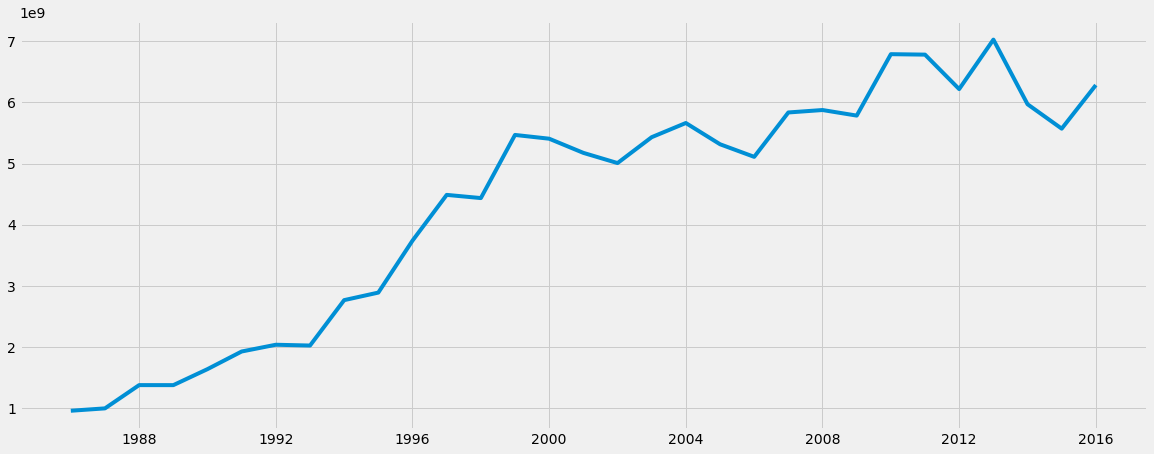

In [186]:
plt.plot(budget_year)

In [187]:
decomposition = sm.tsa.seasonal_decompose(budget_year, model='additive')

In [188]:
from pylab import rcParams # This will define a fixed size for all special charts

rcParams['figure.figsize'] = 18, 7

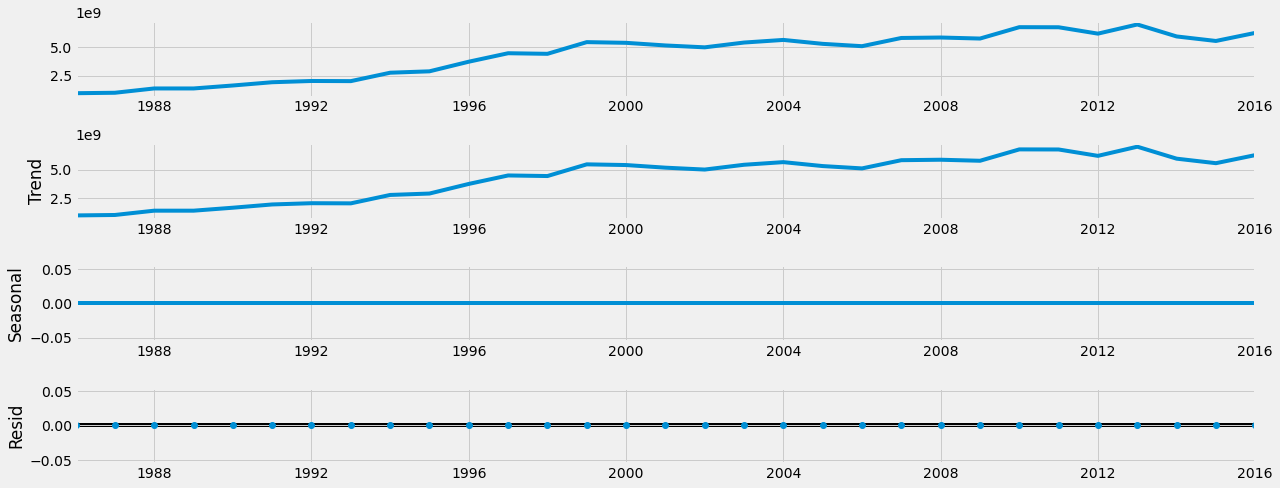

In [189]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [149]:
# The adfuller() function will import from the model from statsmodels for the test

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(budget_year['budget'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.036686
p-value                         0.270723
Number of Lags Used             3.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


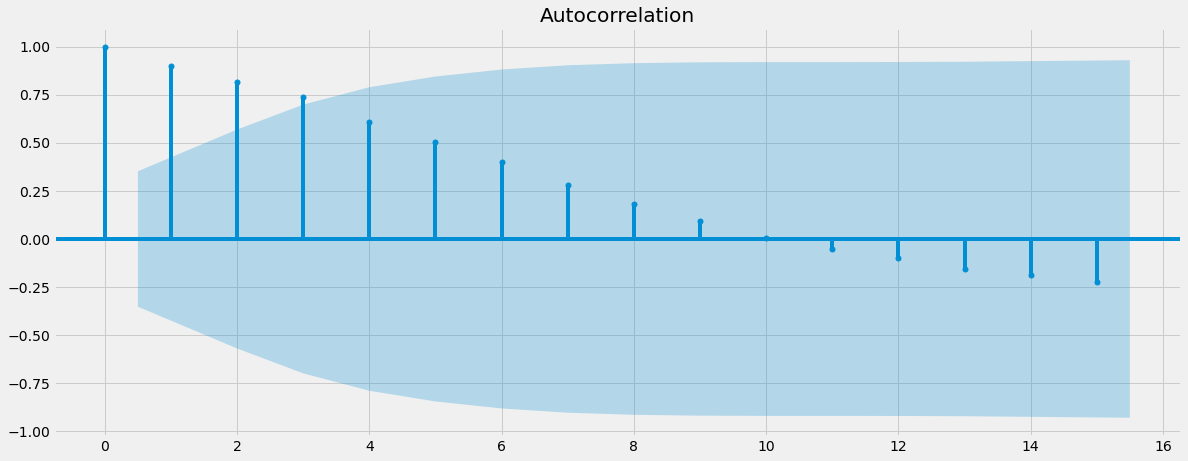

In [150]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Here, I am importing the autocorrelation and partial correlation plots

plot_acf(budget_year)
plt.show()

### 5. Stationarizing the Data

In [151]:
budget_year_new = budget_year - budget_year.shift(1)
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [152]:
budget_year_new.dropna(inplace = True)
# Here, I'm removing the missing values that came about as a result of the differencing
# I need to remove these or I won't be able to run the Dickey-Fuller test

In [153]:
budget_year_new.head()

,budget
datetime,
1987-01-01,38757624.0
1988-01-01,380255000.0
1989-01-01,-325000.0
1990-01-01,261642000.0
1991-01-01,288004000.0


In [155]:
budget_year_new.columns

Index(['budget'], dtype='object')

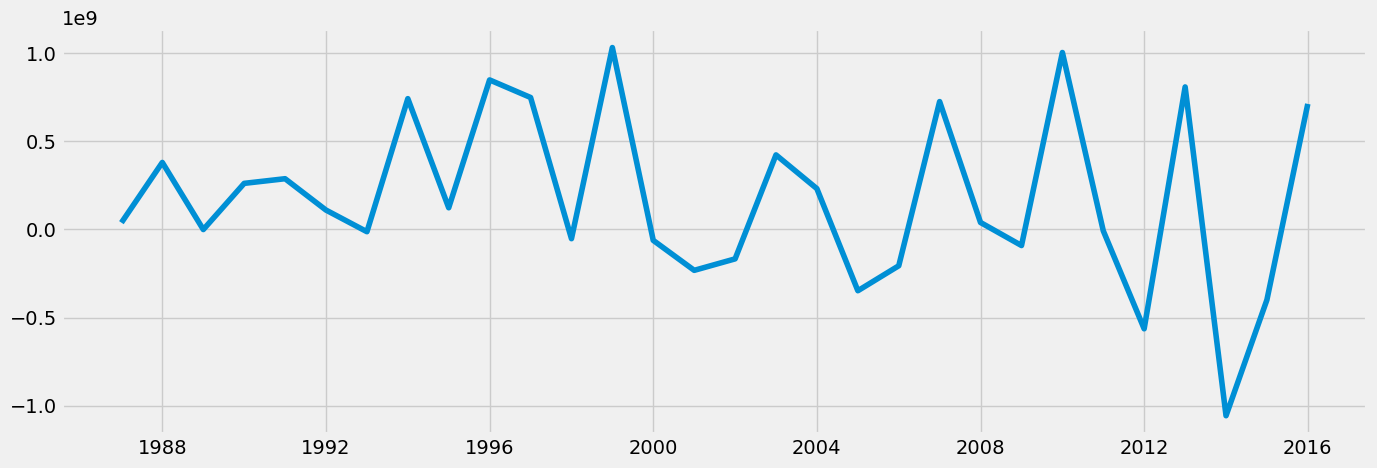

In [156]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(budget_year_new)

In [157]:
dickey_fuller(budget_year_new)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.517656
p-value                         0.524760
Number of Lags Used             2.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


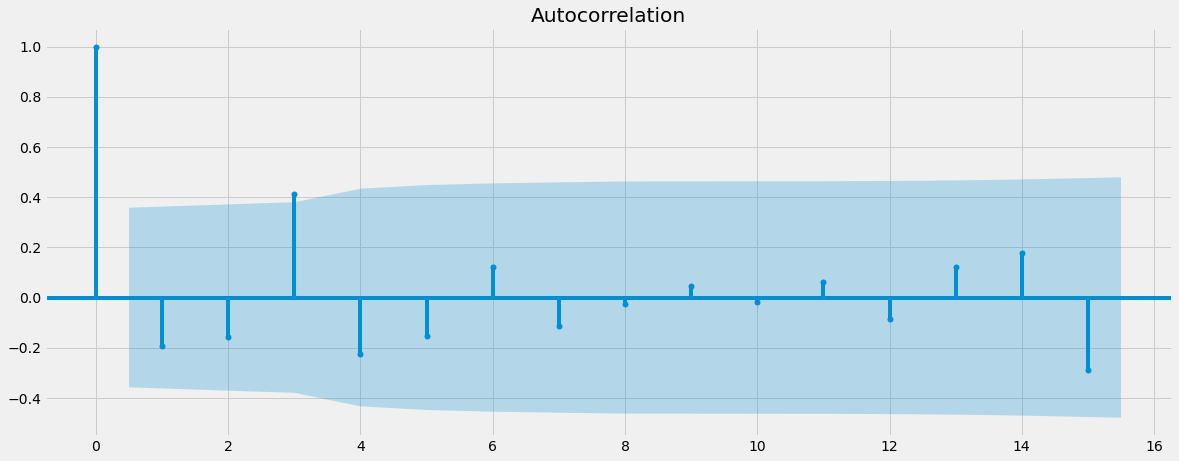

In [158]:
plot_acf(budget_year_new)
plt.show()